In [3]:
import torch
from torch.optim import SparseAdam
from torch.utils.data import DataLoader

import dgl
from dgl.nn.pytorch import MetaPath2Vec

import pickle

In [2]:
def load_pickle(name:str):
    with open(f'{name}.pickle','rb') as f:
        return pickle.load(f)

wiki_dict = load_pickle("wiki_dict")
csv_dict = load_pickle("csv_dict")
csv2wiki = load_pickle("csv2wiki")
wiki2csv = load_pickle("wiki2csv")


In [4]:
# related_by

def make_node(dic : dict):
    
    csv_node = []
    wiki_node = []

    for key in dic.keys():
        for value in dic[key]:
            csv_node.append(key)
            wiki_node.append(value)
            
    return csv_node, wiki_node


In [5]:
related_by_csv, related_by_wiki = make_node(csv2wiki)
related_wiki, related_csv = make_node(wiki2csv)


In [6]:

data_dict = {
                ("csv","related_by","wiki") : (related_by_csv, related_by_wiki) ,
                ("wiki","related","csv") : (related_wiki, related_csv)
            }


graph = dgl.heterograph(data_dict)


In [7]:
graph

Graph(num_nodes={'csv': 12, 'wiki': 106},
      num_edges={('csv', 'related_by', 'wiki'): 168, ('wiki', 'related', 'csv'): 168},
      metagraph=[('csv', 'wiki', 'related_by'), ('wiki', 'csv', 'related')])

# model

In [152]:
random_walks_length = 40
ratio = random_walks_length // 2
window_size = 5
negative_size = 3
MetaPath = ["related_by", "related"] * ratio
model = MetaPath2Vec(graph, MetaPath, window_size = window_size, negative_size = negative_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 819.64it/s]


In [153]:
model

MetaPath2Vec(
  (node_embed): Embedding(118, 128, sparse=True)
  (context_embed): Embedding(118, 128, sparse=True)
)

In [154]:

dataloader = DataLoader(torch.arange(graph.num_nodes('csv')), batch_size = 128, shuffle = True, collate_fn = model.sample)
optimizer = SparseAdam(model.parameters(), lr = 0.01)



In [155]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [156]:
model = model.to(device)

In [157]:
next(iter(dataloader))[0].shape

torch.Size([4500])

In [158]:
epochs = 100

In [159]:
def train(epochs):
    
    total_loss = []
    
    for epoch in range(epochs):
        #print(f"[epoch{epoch:04d}]")
        
        epoch_loss = 0
        for (pos_u, pos_v, neg_v) in dataloader:


            pos_u = pos_u.to(device)
            pos_v = pos_v.to(device)
            neg_v = neg_v.to(device)

            # forward
            loss = model(pos_u, pos_v, neg_v)
            epoch_loss += loss.item()

            #print(f"loss = {loss:.4f}")

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        total_loss.append(epoch_loss / len(dataloader))
    
    return total_loss
            

def draw_loss(x : range, y : list) -> None:
    sns.lineplot(x = x, y = y)

def train_and_drawloss(epochs):
    draw_loss(range(epochs), train(epochs))
    


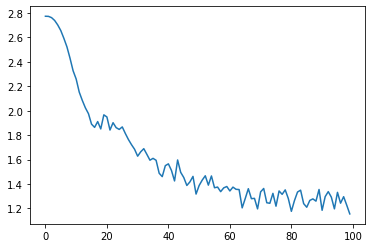

In [160]:
epochs = 100

train_and_drawloss(epochs)

In [162]:
!nvidia-smi

Fri Mar 24 16:17:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 46%   41C    P8    26W / 370W |   1049MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

# Save the Graph and Node Embedding

In [167]:
Embedding = model.node_embed.weight.detach().cpu().numpy()
Embedding

array([[-0.14010271, -0.02599281,  0.27408934, ...,  0.11904889,
         0.23313086,  0.16958776],
       [-0.12241571, -0.2223249 , -0.33095533, ...,  0.2243254 ,
        -0.04250657,  0.09339186],
       [-0.23974529, -0.15623267, -0.02023898, ...,  0.08018677,
        -0.0486981 ,  0.1061918 ],
       ...,
       [-0.34579408, -0.25645423, -0.20523408, ...,  0.40031806,
         0.41829586,  0.2993784 ],
       [-0.33828157, -0.23847388, -0.15224227, ...,  0.40729636,
         0.38762233,  0.29141828],
       [-0.32184985, -0.22683224, -0.16648847, ...,  0.40308186,
         0.40062132,  0.28597674]], dtype=float32)

In [168]:
with open("Embedding", "wb") as f:
    pickle.dump(Embedding, f, pickle.HIGHEST_PROTOCOL)


In [169]:
with open("csv_wiki_graph", "wb") as f:
    pickle.dump(graph, f, pickle.HIGHEST_PROTOCOL)



In [170]:
!ls

Concept-Extraction	 Kaggle.ipynb
content.csv		 learning-equality-curriculum-recommendations.zip
correlations.csv	 MetaPath2Vec.ipynb
csv2wiki.pickle		 Preprocess.ipynb
csv_dict.pickle		 sample_submission.csv
csv_keywords_df.csv	 topics.csv
csv_wiki_graph		 Untitled.ipynb
data.pickle		 wiki2csv.pickle
Deepwalk.ipynb		 wiki_dict.pickle
Deepwalk_practice.ipynb  Wikipedia.ipynb
Embedding


In [175]:
with open("csv_wiki_graph", "rb") as f:
    d = pickle.load(f)

In [176]:
d

Graph(num_nodes={'csv': 12, 'wiki': 106},
      num_edges={('csv', 'related_by', 'wiki'): 168, ('wiki', 'related', 'csv'): 168},
      metagraph=[('csv', 'wiki', 'related_by'), ('wiki', 'csv', 'related')])

In [177]:
!du -sh *

57M	Concept-Extraction
816K	Deepwalk.ipynb
40K	Deepwalk_practice.ipynb
60K	Embedding
28K	Kaggle.ipynb
32K	MetaPath2Vec.ipynb
20K	Preprocess.ipynb
4.0K	Untitled.ipynb
52K	Wikipedia.ipynb
832M	content.csv
4.9M	correlations.csv
4.0K	csv2wiki.pickle
4.0K	csv_dict.pickle
80K	csv_keywords_df.csv
8.0K	csv_wiki_graph
4.0K	data.pickle
254M	learning-equality-curriculum-recommendations.zip
4.0K	sample_submission.csv
14M	topics.csv
4.0K	wiki2csv.pickle
4.0K	wiki_dict.pickle
